<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/itkimage2segimageNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the last step in the split workflow on Terra

The NIFTI files generated from Totalsegmentator are provided as input and the DICOM files are downloaded again to generate DICOM SEG Objects

Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

In [ ]:
import sys
from pathlib import Path
import time
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Fri Mar 24 17:52:58 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Installing Packages

In [ ]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 

In [ ]:
# %%capture
# dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_download_path = f"{curr_dir}/dcmqi-1.2.5-linux.tar.gz"
# dcmqi_path = f"{curr_dir}/dcmqi-1.2.5-linux"

# !wget -O $dcmqi_download_path $dcmqi_release_url

# !tar -xvf $dcmqi_download_path 

# !mv $dcmqi_path/bin/* /bin
# !rm -r $dcmqi_download_path $dcmqi_path

In [ ]:
# %%capture
# #install s5cmd
# !wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
# !tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
# !mv s5cmd /usr/local/bin/s5cmd

###Parameters

In [ ]:
csvFilePath=''
inferenceNiftiFilePath=''

###Extracting Inference NIFTI files

In [ ]:
import shutil
import glob
import os
try:
  shutil.rmtree(f'Inference')
except OSError:
  pass

#Get the file path of the inferenceNiftiFiles

#lz4_file_path = '/content/drive/MyDrive/idc_vamsi/inferenceNiftiFiles.tar.lz4'

!lz4 -d {inferenceNiftiFilePath} -c | tar xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/inferenceNiftiFiles.tar.lz4 -c | tar xvf -

Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/preview_total.png
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/statistics_radiomics.json
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/pr

###Reading CSV File containing s5cmd Urls

In [ ]:
import sys
import time
import pandas as pd
from pathlib import Path

In [ ]:
#get the path of the zip file containing csv file in the current working directory
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.

#Since it will be the only zip file that will be provided as input, we will be unzipping 
#the first zip file in the current working directory.

import glob

#zip_file_path = glob.glob('*.zip')[0]
#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path = glob.glob('*.csv')[0]
#csv_file_path= '/home/vamsi/Downloads/result.csv'

start_time = time.time()
#cohort_df=pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
#cohort_df= pd.read_csv('/content/drive/MyDrive/bq-results-20230315-160529-1678896367937/bq-results-20230315-160529-1678896367937.csv')
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

read in 0.3558692932128906  seconds


###Functions

In [ ]:
try:
  shutil.rmtree(f'itkimage2segimage')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

In [ ]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [ ]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole.json')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json

--2023-03-24 17:53:05--  https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80391 (79K) [text/plain]
Saving to: ‘dicomseg_metadata_whole.json’

dicomseg_metadata_w 100%[===================>]  78.51K  --.-KB/s    in 0.01s   

2023-03-24 17:53:05 (6.25 MB/s) - ‘dicomseg_metadata_whole.json’ saved [80391/80391]



In [ ]:
def itkimage2segimage(series_id):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')

      print("Processing series: "+series_id)  

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """
      download_dicom_data(series_id) 


      #Get Inference NIFTI file path
      inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii')
      inference_list = []
      inference_list.append(inference_nifti_filename)

      try:
        os.remove(inference_nifti_filename)
      except OSError:
        pass
      !lz4 -d {inference_nifti_filename_path}
      #remove the compressed file after decompressing
      !rm -r {inference_nifti_filename_path}
       
      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/{series_id}/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("Done in %g seconds."%itkimage2segimage_time)

      start_time = time.time()     
      !lz4 {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      archiving_time = time.time() - start_time
      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}
      !rm -r {curr_dir}/idc_data/{series_id}
      !rm -r {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405
Copying files from IDC buckets..
Done in 2.79316 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405.nii 
/content/Inference/1 : decoded 109587904 bytes 
Done in 133.806 seconds.
Compressed 308481060 bytes into 1988779 bytes ==> 0.64%


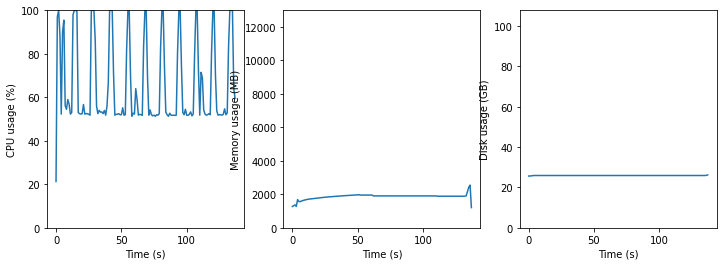

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411
Copying files from IDC buckets..
Done in 1.52317 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411.nii 
/content/Inference/1 : decoded 113782208 bytes 
Done in 141.357 seconds.
Compressed 320676862 bytes into 2135714 bytes ==> 0.67%


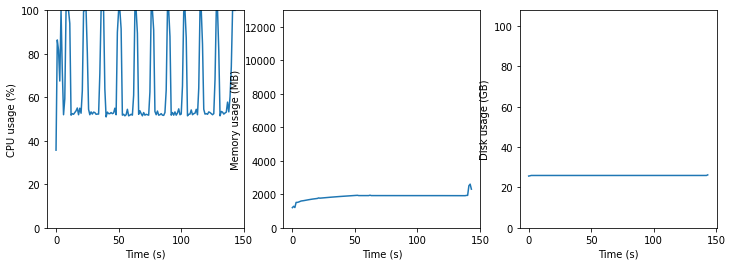

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081
Copying files from IDC buckets..
Done in 1.43325 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081.nii 
/content/Inference/1 : decoded 115879360 bytes 
Done in 144.889 seconds.
Compressed 328018268 bytes into 2076411 bytes ==> 0.63%


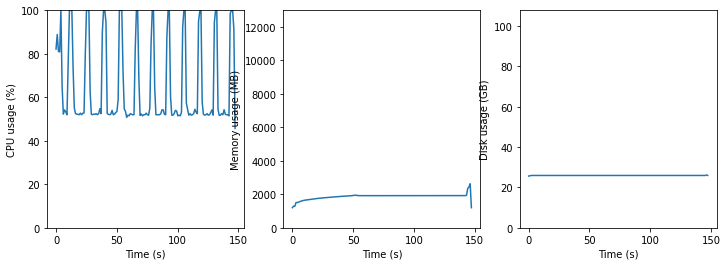

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271
Copying files from IDC buckets..
Done in 1.62975 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271.nii 
/content/Inference/1 : decoded 105917888 bytes 
Done in 126.792 seconds.
Compressed 292978892 bytes into 1937985 bytes ==> 0.66%


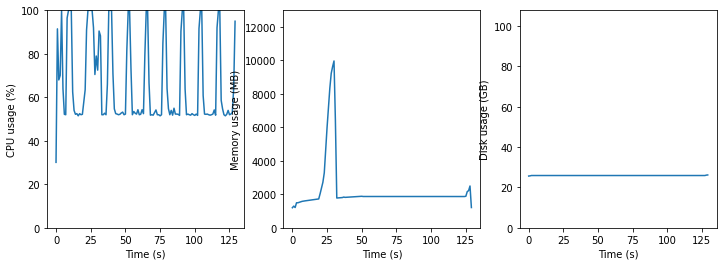

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699
Copying files from IDC buckets..
Done in 2.23431 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699.nii 
/content/Inference/1 : decoded 115092928 bytes 
Done in 140.542 seconds.
Compressed 319250054 bytes into 2012422 bytes ==> 0.63%


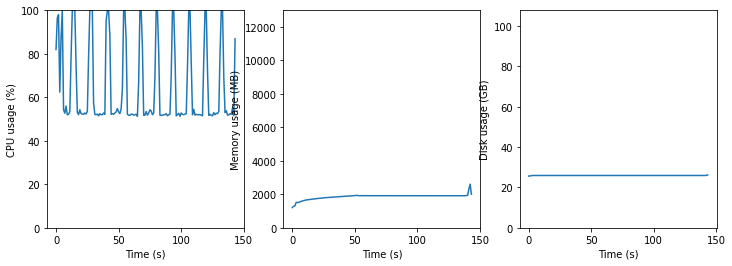

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105
Copying files from IDC buckets..
Done in 2.243 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105.nii 
/content/Inference/1 : decoded 108539328 bytes 
Done in 125.541 seconds.
Compressed 303680526 bytes into 1926384 bytes ==> 0.63%


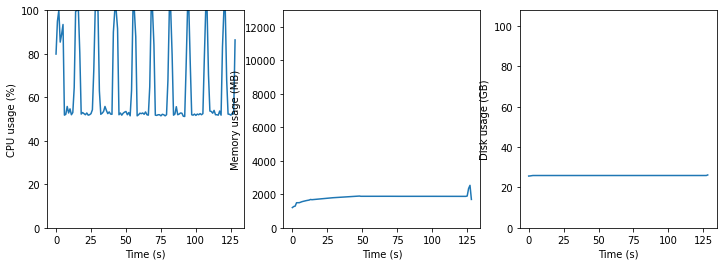

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655
Copying files from IDC buckets..
Done in 1.65867 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655/1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655.nii 
/content/Inference/1 : decoded 119287232 bytes 
Done in 153.916 seconds.
Compressed 332119944 bytes into 2173713 bytes ==> 0.65%


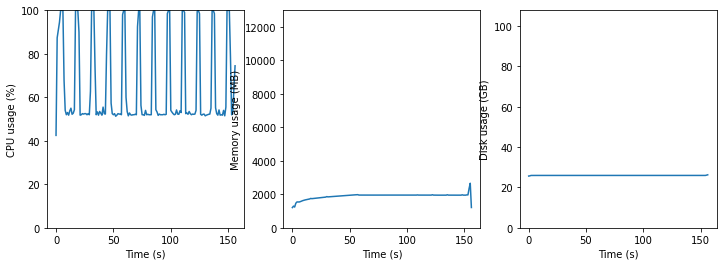

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814
Copying files from IDC buckets..
Done in 1.93473 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814/1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814.nii 
/content/Inference/1 : decoded 111947200 bytes 
Done in 126.818 seconds.
Compressed 290249322 bytes into 1855563 bytes ==> 0.64%


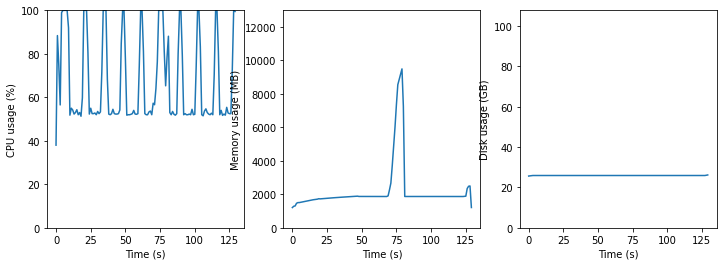

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504
Copying files from IDC buckets..
Done in 1.63619 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504.nii 
/content/Inference/1 : decoded 113257920 bytes 
Done in 113.452 seconds.
Compressed 280197160 bytes into 1865902 bytes ==> 0.67%


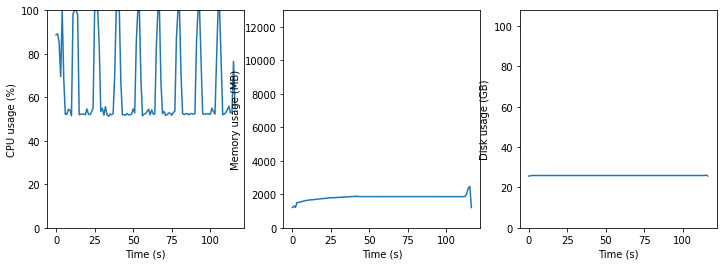

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262
Copying files from IDC buckets..
Done in 1.95828 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262.nii 
/content/Inference/1 : decoded 85208512 bytes 
Done in 70.0613 seconds.
Compressed 220762654 bytes into 1391510 bytes ==> 0.63%


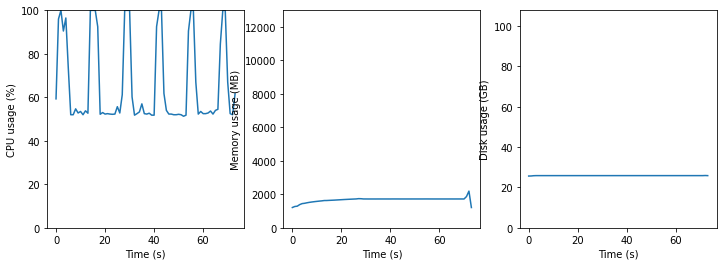

In [ ]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'{curr_dir}/Inference'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimage, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > /content/itkimage2segimageDICOMsegFiles.tar.lz4
archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081.dcm.lz4
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/
/content/itkimage2segimage/1.3.6.1.4.1.14519.5.2.1.7009.9004.

###Utilization Metrics

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('itkimage2segimageUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv itkimage2segimageUsageMetrics.lz4
runtime_stats

Compressed 53924 bytes into 15327 bytes ==> 28.42%


,SeriesInstanceUID,itkimage2segimage_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140...,133.806012,0.228884,"[[[21.3, 97.0, 100.0, 88.4, 52.3, 90.0, 95.5, ...","[[[1272.0859375, 1320.33984375, 1368.8203125, ...",[12985.5390625],"[[[25.643573760986328, 25.65420913696289, 25.7...",107.715084
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147...,141.357235,0.228884,"[[[35.7, 86.4, 81.7, 67.5, 100.0, 72.5, 52.0, ...","[[[1202.48046875, 1283.90234375, 1209.4765625,...",[12985.5390625],"[[[25.64309310913086, 25.750957489013672, 25.9...",107.715084
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831...,144.888571,0.228884,"[[[82.2, 88.9, 81.1, 80.9, 100.0, 64.8, 52.3, ...","[[[1201.77734375, 1291.58203125, 1283.42578125...",[12985.5390625],"[[[25.642581939697266, 25.73602294921875, 25.9...",107.715084
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370...,126.792369,0.228884,"[[[30.1, 91.5, 68.0, 70.1, 100.0, 64.0, 52.2, ...","[[[1198.0, 1295.22265625, 1211.0859375, 1494.6...",[12985.5390625],"[[[25.642452239990234, 25.72594451904297, 25.9...",107.715084
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428...,140.541703,0.228884,"[[[82.0, 96.5, 98.0, 62.4, 87.1, 100.0, 54.3, ...","[[[1209.12109375, 1283.1796875, 1303.25, 1512....",[12985.5390625],"[[[25.64215850830078, 25.668498992919922, 25.8...",107.715084
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798...,125.540639,0.228884,"[[[79.9, 95.0, 100.0, 85.4, 89.0, 93.5, 51.8, ...","[[[1208.2421875, 1271.171875, 1292.50390625, 1...",[12985.5390625],"[[[25.64188003540039, 25.693214416503906, 25.8...",107.715084
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210...,153.916330,0.228884,"[[[42.5, 87.4, 91.0, 94.5, 100.0, 100.0, 100.0...","[[[1206.91796875, 1295.36328125, 1239.01953125...",[12985.5390625],"[[[25.641902923583984, 25.720718383789062, 25....",107.715084
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052...,126.818180,0.228884,"[[[38.0, 88.4, 74.7, 56.5, 99.0, 100.0, 100.0,...","[[[1208.7421875, 1287.43359375, 1304.3203125, ...",[12985.5390625],"[[[25.640884399414062, 25.726226806640625, 25....",107.715084
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797...,113.452194,0.228884,"[[[88.8, 89.2, 85.3, 69.5, 100.0, 68.3, 52.2, ...","[[[1210.6171875, 1298.375, 1215.09765625, 1510...",[12985.5390625],"[[[25.640602111816406, 25.723392486572266, 25....",107.715084
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705...,70.061328,0.228884,"[[[59.3, 96.0, 100.0, 90.5, 96.5, 73.5, 52.0, ...","[[[1211.97265625, 1272.609375, 1291.69140625, ...",[12985.5390625],"[[[25.63986587524414, 25.671768188476562, 25.7...",107.715084
